# Image Augmentation

Deep learning is a _volume_ game. This means the more data you have, chances are your network will perform better. In fact, if you have just a few hundreds of instances to train, more traditional machine learning models will likely work best. 

But what happen when it is too difficult or impossible to get new data? 

We get to use of a property called **location invariance**. This mensas that an object is still an object independently on where it appears in the images. A Pug is a Pug whether it appears in the lower bottom of a picture or at the center. Even if we tilt, shift or rotate a little bit the picture, the Pug will remain the Pug. 

Knowing this, we can perform a series of small alterations on an image to augment, expand our dataset. So, for instance, if we have 1000 images, and each of them are rotated 10° to the left, 10° to the right and mirrored, our dataset grows to 4000 images, because we're adding three variations of each instance of top of the 1000 we had to begin with.

Let's see how augment a dataset in Keras.

## Load CIFAR-10 Dataset

We'll use CIFAR-10 again.

In [1]:
import keras
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


## Visualize a Sample of Images

Let's take a look at what's inside the dataset.

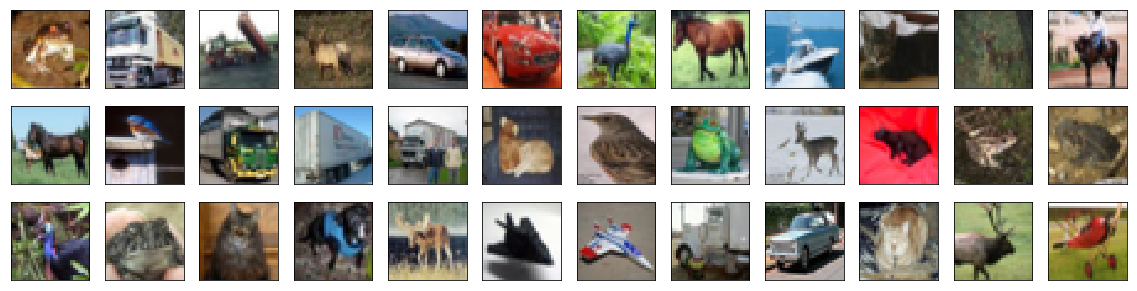

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_SIZE = 36
figure = plt.figure(figsize=(20, 5))
for index in range(SAMPLE_SIZE):
    ax = figure.add_subplot(3, 12, index + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[index]))

## Rescaling

Let's rescale the pixel values by dividing them by 255.

In [3]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## Train, Test and Validation Splits

In [4]:
from keras.utils import np_utils

# One-hot encode the labels
NUMBER_OF_CLASSES = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, NUMBER_OF_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUMBER_OF_CLASSES)

# Break training set into training and validation
split_point = 5000
(X_train, X_valid) = X_train[split_point:], X_train[:split_point]
(y_train, y_valid) = y_train[split_point:], y_train[:split_point]

# Print the shape of each set:
print(f'Shape of the training set: {X_train.shape}')
print(f'Shape of the test set: {X_test.shape}')
print(f'Shape of the validation set: {X_valid.shape}')

# Print the number of elements in each set:
print(f'Number of training instances: {X_train.shape[0]}')
print(f'Number of test instances: {X_test.shape[0]}')
print(f'Number of validation instances: {X_valid.shape[0]}')

Shape of the training set: (45000, 32, 32, 3)
Shape of the test set: (10000, 32, 32, 3)
Shape of the validation set: (5000, 32, 32, 3)
Number of training instances: 45000
Number of test instances: 10000
Number of validation instances: 5000


## Create and Configure an Augmented Image Generator

We can configure a generator in Keras that will yield batches of augmented data based on the transformations we tell it to perform. In this case, we'll augment each image as follows:

- Randomly shift images horizontaly (10% of total width).
- Randomly shift images vertically (10% of total height).
- Randomly flip images horizontally.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

data_generator_train = ImageDataGenerator(width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          horizontal_flip=True)

data_generator_train.fit(X_train)

##  Visualize Original and Augmented Images

Let's take a look at the augmented images the generator produces.

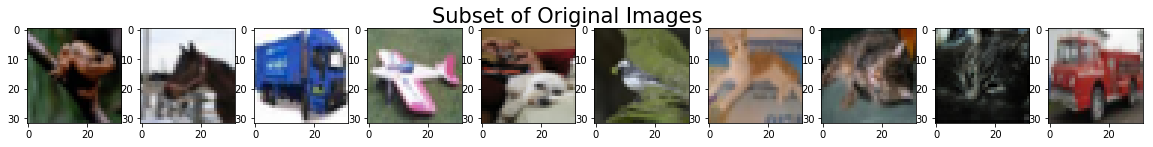

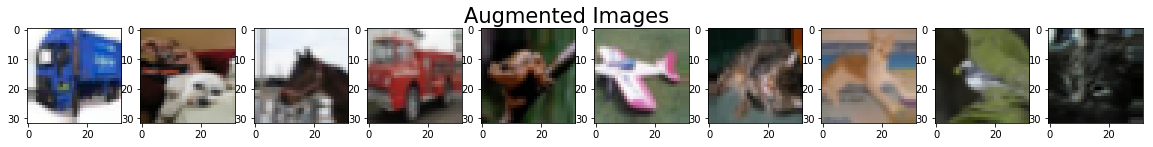

In [6]:
import matplotlib.pyplot as plt

SUBSET_SIZE = 10
X_train_subset = X_train[:SUBSET_SIZE]

# Visualize subset of original training data
figure = plt.figure(figsize=(20, 2))
for index in range(SUBSET_SIZE):
    ax = figure.add_subplot(1, SUBSET_SIZE, index + 1)
    ax.imshow(X_train_subset[index])
    
figure.suptitle('Subset of Original Images', fontsize=21)
plt.show()

# Visualize augmented images
figure = plt.figure(figsize=(20, 2))
for X_batch in data_generator_train.flow(X_train_subset, batch_size=SUBSET_SIZE):
    for index in range(SUBSET_SIZE):
        ax = figure.add_subplot(1, SUBSET_SIZE, index + 1)
        ax.imshow(X_batch[index])
        
    figure.suptitle('Augmented Images', fontsize=21)
    plt.show()
    break

## Define Model Architecture

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Convolution2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
__________

## Compile the Model

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the Model

This time, given we are using a generator, we cannot use the `fit` method. Instead, we'll use the `fit_generator` method.

In [9]:
from keras.callbacks import ModelCheckpoint

def train_model(model, saved_model_output, batch_size, epochs, plot_history=True):
    checkpointer = ModelCheckpoint(filepath=saved_model_output, save_best_only=True)
    
    history = model.fit_generator(
        data_generator_train.flow(X_train, y_train, 
                                  batch_size=batch_size), 
        epochs=epochs, 
        validation_data=(X_valid, y_valid), 
        callbacks=[checkpointer], 
        steps_per_epoch=X_train.shape[0] // batch_size,
        validation_steps=X_valid.shape[0] // batch_size)
    
    if plot_history:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

Epoch 1/100
175/175 [==============================] - 30s 171ms/step - loss: 1.8165 - acc: 0.3396 - val_loss: 1.4869 - val_acc: 0.4732
Epoch 2/100
175/175 [==============================] - 29s 168ms/step - loss: 1.5406 - acc: 0.4409 - val_loss: 1.4319 - val_acc: 0.4892
Epoch 3/100
175/175 [==============================] - 30s 172ms/step - loss: 1.4454 - acc: 0.4778 - val_loss: 1.2782 - val_acc: 0.5440
Epoch 4/100
175/175 [==============================] - 30s 174ms/step - loss: 1.3938 - acc: 0.4990 - val_loss: 1.2688 - val_acc: 0.5438
Epoch 5/100
175/175 [==============================] - 31s 175ms/step - loss: 1.3427 - acc: 0.5184 - val_loss: 1.1902 - val_acc: 0.5802
Epoch 6/100
175/175 [==============================] - 33s 191ms/step - loss: 1.3006 - acc: 0.5340 - val_loss: 1.1717 - val_acc: 0.5786
Epoch 7/100
175/175 [==============================] - 32s 184ms/step - loss: 1.2601 - acc: 0.5489 - val_loss: 1.1213 - val_acc: 0.5980
Epoch 8/100
175/175 [===========================

Epoch 61/100
175/175 [==============================] - 33s 189ms/step - loss: 0.7796 - acc: 0.7260 - val_loss: 0.6891 - val_acc: 0.7566
Epoch 62/100
175/175 [==============================] - 33s 189ms/step - loss: 0.7786 - acc: 0.7259 - val_loss: 0.6879 - val_acc: 0.7650
Epoch 63/100
175/175 [==============================] - 33s 188ms/step - loss: 0.7782 - acc: 0.7251 - val_loss: 0.6688 - val_acc: 0.7678
Epoch 64/100
175/175 [==============================] - 33s 189ms/step - loss: 0.7750 - acc: 0.7254 - val_loss: 0.6848 - val_acc: 0.7618
Epoch 65/100
175/175 [==============================] - 33s 190ms/step - loss: 0.7679 - acc: 0.7269 - val_loss: 0.6919 - val_acc: 0.7548
Epoch 66/100
175/175 [==============================] - 33s 191ms/step - loss: 0.7652 - acc: 0.7319 - val_loss: 0.6505 - val_acc: 0.7768
Epoch 67/100
175/175 [==============================] - 33s 190ms/step - loss: 0.7592 - acc: 0.7333 - val_loss: 0.6752 - val_acc: 0.7650
Epoch 68/100
175/175 [===================

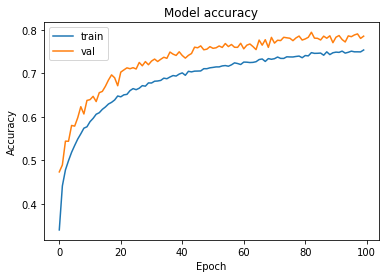

In [10]:
CNN_BEST_MODEL_OUTPUT = 'saved_models/cnn.cifar10.augmented.best.hdf5'

EPOCHS = 100
BATCH_SIZE = 256
train_model(model, CNN_BEST_MODEL_OUTPUT, BATCH_SIZE, EPOCHS)

## Load Best Model

Let's load the best model that resulted from the training process and see how it performs on unseen data.

In [11]:
model.load_weights(CNN_BEST_MODEL_OUTPUT)

score = model.evaluate(X_test, y_test)
print(f'CNN test accuracy: {100 * score[1]}%')

10000/10000 [==============================] - 2s 234us/step
CNN test accuracy: 78.24%


Using image augmentation bumped up the _accuracy_ of our CNN around 6%.